In [1]:
import time
import random
import numpy as np
import pandas as pd
import polars as pl
from ipywidgets import interact
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## A) Polars vs Pandas

In [2]:
def log_time(message, start_time=None):
    if start_time:
        elapsed_time = time.time() - start_time
        print(f"[{elapsed_time:.2f} seconds] {message}")
    else:
        print(f"[0.00 seconds] {message}")

In [3]:
start_time = time.time()
polars = pl.read_csv('all_stocks_5yr.csv', try_parse_dates=True)
log_time("Polars Dataset loaded", start_time)

start_time = time.time()
pandas = pd.read_csv('all_stocks_5yr.csv')
log_time("pandas Dataset loaded", start_time)

[0.45 seconds] Polars Dataset loaded
[0.67 seconds] pandas Dataset loaded


> Polars open dataset fast than Pandas

In [4]:
start_time = time.time()
print(polars.schema)
log_time("Polars Time", start_time)
print("\n")
start_time = time.time()
pandas.info()
print("\n")
log_time(" pandas time", start_time)

Schema([('date', Date), ('open', Float64), ('high', Float64), ('low', Float64), ('close', Float64), ('volume', Int64), ('name', String)])
[0.00 seconds] Polars Time


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


[0.29 seconds]  pandas time


> Pandas has better information of data than Polars although time difference in this case is somewhat similar

In [5]:
polars.describe()

statistic,date,open,high,low,close,volume,name
str,str,f64,f64,f64,f64,f64,str
"""count""","""619040""",619029.0,619032.0,619032.0,619040.0,619040.0,"""619040"""
"""null_count""","""0""",11.0,8.0,8.0,0.0,0.0,"""0"""
"""mean""","""2015-08-18 00:48:23.494000""",83.023334,83.778311,82.256096,83.043763,4.3218e6,null
"""std""",null,97.378769,98.207519,96.507421,97.389748,8.6936e6,null
"""min""","""2013-02-08""",1.62,1.69,1.5,1.59,0.0,"""A"""
"""25%""","""2014-05-20""",40.22,40.62,39.83,40.245,1.070325e6,null
"""50%""","""2015-08-21""",62.59,63.15,62.02,62.62,2.082097e6,null
"""75%""","""2016-11-15""",94.37,95.18,93.54,94.41,4.284507e6,null
"""max""","""2018-02-07""",2044.0,2067.99,2035.11,2049.0,6.1823763e8,"""ZTS"""


In [6]:
pandas.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


> Pandas has better visual appearance than polars

In [7]:
start_time = time.time()
print(polars.shape)
log_time("Polars time", start_time)
start_time = time.time()
print(pandas.shape)
log_time(" pandas time", start_time)

(619040, 7)
[0.00 seconds] Polars time
(619040, 7)
[0.00 seconds]  pandas time


## <center>  Pandas vs Polars Comparison </center>

| **Feature**         | **Pandas**                                          | **Polars**                                                    |
|---------------------|-----------------------------------------------------|-----------------------------------------------------------------|
| **Performance**     | Great for small to medium datasets                  | Highly optimized for large datasets with multi-threading      |
| **Memory Usage**    | Can use more memory for larger operations           | More memory efficient due to optimized engine                  |
| **API & Stability** | Mature and widely used; stable API                  | Newer and evolving; API similar to Pandas but still maturing     |
| **Multi-threading** | Single-threaded by default                          | Built-in support for multi-threading and parallel processing     |
| **Lazy Evaluation** | Not available                                       | Supports lazy evaluation, which can optimize query performance   |
| **Community Support** | Extensive community and rich ecosystem           | Growing community; less mature but rapidly developing             |

## <center> Conclusion </center>
> For our analysis of 5-year stock data, we are going to use **Polars** due to its superior speed and efficiency in handling large datasets.

## B) Analysis

In [8]:
pandas.shape

(619040, 7)

In [9]:
duplicates = polars.filter(polars.is_duplicated())
print(duplicates)

shape: (0, 7)
┌──────┬──────┬──────┬─────┬───────┬────────┬──────┐
│ date ┆ open ┆ high ┆ low ┆ close ┆ volume ┆ name │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    ┆ ---  │
│ date ┆ f64  ┆ f64  ┆ f64 ┆ f64   ┆ i64    ┆ str  │
╞══════╪══════╪══════╪═════╪═══════╪════════╪══════╡
└──────┴──────┴──────┴─────┴───────┴────────┴──────┘


In [10]:
polars = polars.unique(maintain_order=True)
print(polars)

shape: (619_040, 7)
┌────────────┬───────┬───────┬───────┬───────┬──────────┬──────┐
│ date       ┆ open  ┆ high  ┆ low   ┆ close ┆ volume   ┆ name │
│ ---        ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---      ┆ ---  │
│ date       ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ i64      ┆ str  │
╞════════════╪═══════╪═══════╪═══════╪═══════╪══════════╪══════╡
│ 2013-02-08 ┆ 15.07 ┆ 15.12 ┆ 14.63 ┆ 14.75 ┆ 8407500  ┆ AAL  │
│ 2013-02-11 ┆ 14.89 ┆ 15.01 ┆ 14.26 ┆ 14.46 ┆ 8882000  ┆ AAL  │
│ 2013-02-12 ┆ 14.45 ┆ 14.51 ┆ 14.1  ┆ 14.27 ┆ 8126000  ┆ AAL  │
│ 2013-02-13 ┆ 14.3  ┆ 14.94 ┆ 14.25 ┆ 14.66 ┆ 10259500 ┆ AAL  │
│ 2013-02-14 ┆ 14.94 ┆ 14.96 ┆ 13.16 ┆ 13.99 ┆ 31879900 ┆ AAL  │
│ …          ┆ …     ┆ …     ┆ …     ┆ …     ┆ …        ┆ …    │
│ 2018-02-01 ┆ 76.84 ┆ 78.27 ┆ 76.69 ┆ 77.82 ┆ 2982259  ┆ ZTS  │
│ 2018-02-02 ┆ 77.53 ┆ 78.12 ┆ 76.73 ┆ 76.78 ┆ 2595187  ┆ ZTS  │
│ 2018-02-05 ┆ 76.64 ┆ 76.92 ┆ 73.18 ┆ 73.83 ┆ 2962031  ┆ ZTS  │
│ 2018-02-06 ┆ 72.74 ┆ 74.56 ┆ 72.13 ┆ 73.27 ┆ 4924323  ┆ ZTS  │
│ 201

In [11]:
null_counts = polars.select(pl.all().is_null().sum())
print(null_counts)

shape: (1, 7)
┌──────┬──────┬──────┬─────┬───────┬────────┬──────┐
│ date ┆ open ┆ high ┆ low ┆ close ┆ volume ┆ name │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---    ┆ ---  │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32    ┆ u32  │
╞══════╪══════╪══════╪═════╪═══════╪════════╪══════╡
│ 0    ┆ 11   ┆ 8    ┆ 8   ┆ 0     ┆ 0      ┆ 0    │
└──────┴──────┴──────┴─────┴───────┴────────┴──────┘


In [12]:
polars.drop_nulls()

date,open,high,low,close,volume,name
date,f64,f64,f64,f64,i64,str
2013-02-08,15.07,15.12,14.63,14.75,8407500,"""AAL"""
2013-02-11,14.89,15.01,14.26,14.46,8882000,"""AAL"""
2013-02-12,14.45,14.51,14.1,14.27,8126000,"""AAL"""
2013-02-13,14.3,14.94,14.25,14.66,10259500,"""AAL"""
2013-02-14,14.94,14.96,13.16,13.99,31879900,"""AAL"""
…,…,…,…,…,…,…
2018-02-01,76.84,78.27,76.69,77.82,2982259,"""ZTS"""
2018-02-02,77.53,78.12,76.73,76.78,2595187,"""ZTS"""
2018-02-05,76.64,76.92,73.18,73.83,2962031,"""ZTS"""


In [13]:
polars = polars.with_columns(pl.col("date").cast(pl.Utf8))
polars = polars.with_columns(pl.col("date").str.to_date())
polars = polars.sort("name", "date")

## C) 4 technical indicators

In [14]:
def calculate_indicators(polars):
    return polars.with_columns(
        pl.col("close").ewm_mean(span=10).alias("EMA_10"),
        (pl.col("close").ewm_mean(span=12) - pl.col("close").ewm_mean(span=26)).alias("MACD"),
        ((pl.col("high").rolling_max(window_size=14) - pl.col("close")) / 
         (pl.col("high").rolling_max(window_size=14) - pl.col("low").rolling_min(window_size=14)) * -100).alias("Williams_%R"),
        (pl.max_horizontal([
            pl.col("high") - pl.col("low"),
            (pl.col("high") - pl.col("close").shift(1)).abs(),
            (pl.col("low") - pl.col("close").shift(1)).abs()
        ]).rolling_mean(window_size=14)).alias("ATR_14")
    )

In [15]:
polars = calculate_indicators(polars)

In [16]:
## Checking NaN values
null_counts = polars.select(pl.all().is_null().sum())
print(null_counts)

shape: (1, 11)
┌──────┬──────┬──────┬─────┬───┬────────┬──────┬─────────────┬────────┐
│ date ┆ open ┆ high ┆ low ┆ … ┆ EMA_10 ┆ MACD ┆ Williams_%R ┆ ATR_14 │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆   ┆ ---    ┆ ---  ┆ ---         ┆ ---    │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆   ┆ u32    ┆ u32  ┆ u32         ┆ u32    │
╞══════╪══════╪══════╪═════╪═══╪════════╪══════╪═════════════╪════════╡
│ 0    ┆ 11   ┆ 8    ┆ 8   ┆ … ┆ 0      ┆ 0    ┆ 125         ┆ 125    │
└──────┴──────┴──────┴─────┴───┴────────┴──────┴─────────────┴────────┘


In [17]:
## Drop NaN values
polars = polars.drop_nulls()

In [18]:
## Check first five data
polars.head()

date,open,high,low,close,volume,name,EMA_10,MACD,Williams_%R,ATR_14
date,f64,f64,f64,f64,i64,str,f64,f64,f64,f64
2013-02-28,41.78,42.06,41.45,41.48,3464202,"""A""",41.974469,-0.377195,-75.0,0.829286
2013-03-01,41.18,41.98,40.73,41.93,3089323,"""A""",41.965964,-0.345576,-65.544554,0.893571
2013-03-04,41.75,42.18,41.52,42.03,2435306,"""A""",41.978096,-0.311175,-63.564356,0.888571
2013-03-05,42.35,43.19,42.34,42.66,3289188,"""A""",42.106309,-0.242091,-51.089109,0.939286
2013-03-06,43.0,43.52,42.9,43.24,2996908,"""A""",42.318154,-0.149643,-33.551198,0.956429


polars.unique

## D) Visualisation

Enter company name (e.g., AAPL, GOOG, MSFT):  AAPL


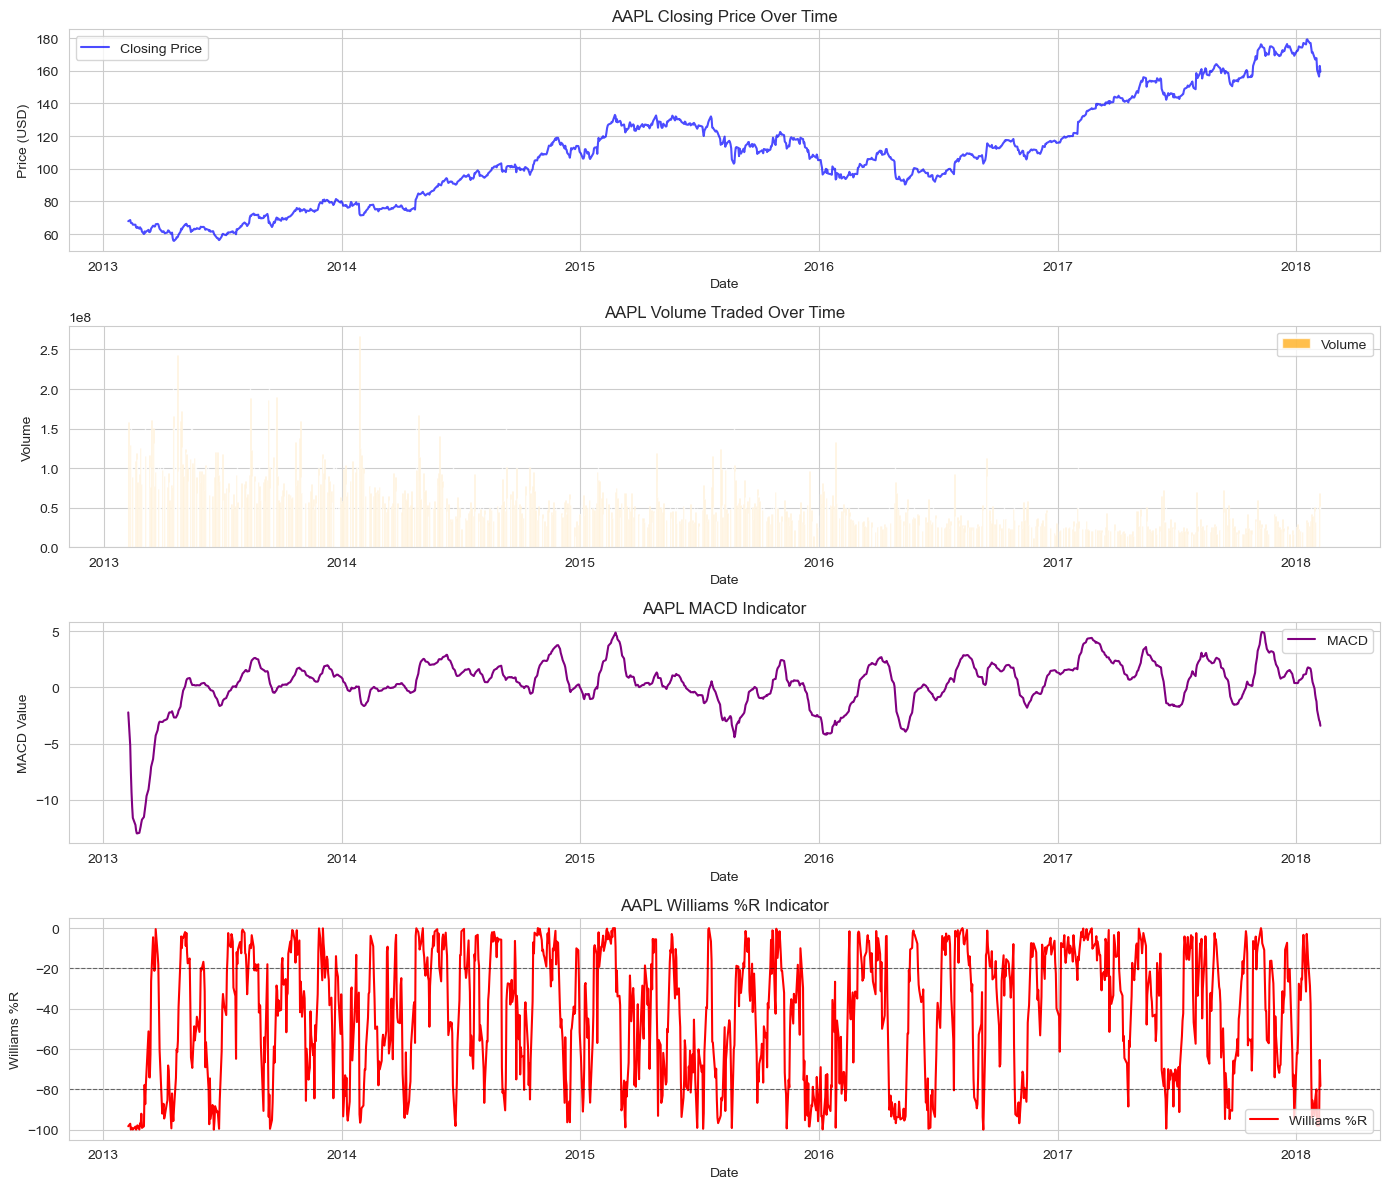

In [19]:
# User selects company
company = input("Enter company name (e.g., AAPL, GOOG, MSFT): ")
df_company = polars.filter(pl.col('name') == company).sort('date')

# Convert Polars DataFrame to Pandas for visualization
df_company_pd = df_company.to_pandas()

# Set visualization style
sns.set_style("whitegrid")

# Create a figure for subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Closing Price
axes[0].plot(df_company_pd['date'], df_company_pd['close'], label='Closing Price', color='blue', alpha=0.7)
axes[0].set_title(f'{company} Closing Price Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Volume Traded Over Time
axes[1].bar(df_company_pd['date'], df_company_pd['volume'], color='orange', alpha=0.7, label='Volume')
axes[1].set_title(f'{company} Volume Traded Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].legend()

# MACD Indicator
axes[2].plot(df_company_pd['date'], df_company_pd['MACD'], label='MACD', color='purple')
axes[2].set_title(f'{company} MACD Indicator')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('MACD Value')
axes[2].legend()

# Williams %R Indicator
axes[3].plot(df_company_pd['date'], df_company_pd['Williams_%R'], label='Williams %R', color='red')
axes[3].set_title(f'{company} Williams %R Indicator')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Williams %R')
axes[3].axhline(y=-20, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[3].axhline(y=-80, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[3].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Available companies:
['HOG', 'AVY', 'WRK', 'DOV', 'RJF', 'LMT', 'CMI', 'TSN', 'MO', 'VMC', 'FLS', 'ADP', 'WYNN', 'CVS', 'PNC', 'AAPL', 'BLL', 'ZTS', 'CMCSA', 'ALGN', 'MTD', 'OMC', 'UHS', 'AXP', 'BXP', 'AJG', 'TAP', 'LKQ', 'AET', 'MS', 'PSX', 'FOXA', 'AZO', 'CMA', 'DTE', 'HCN', 'F', 'NTAP', 'NBL', 'DAL', 'MMM', 'SHW', 'CBG', 'MRK', 'DGX', 'CME', 'AVGO', 'MU', 'PM', 'FISV', 'INTC', 'PCAR', 'JPM', 'CDNS', 'EBAY', 'LYB', 'KR', 'WAT', 'DISCA', 'TXN', 'SEE', 'IRM', 'UNM', 'AEE', 'LUV', 'CPB', 'NFX', 'GPN', 'CTXS', 'ORLY', 'BBT', 'AYI', 'COP', 'VRTX', 'PH', 'NEE', 'FFIV', 'SRCL', 'PEP', 'WEC', 'PKG', 'GM', 'WY', 'CLX', 'BF.B', 'ETR', 'NTRS', 'DISH', 'KMI', 'AON', 'ALLE', 'TSCO', 'VIAB', 'EL', 'COST', 'JNJ', 'DFS', 'COG', 'QRVO', 'ADM', 'HCA', 'ES', 'ED', 'TXT', 'TROW', 'MDLZ', 'OKE', 'JCI', 'PBCT', 'SYMC', 'MA', 'AIG', 'APA', 'AMT', 'DVA', 'VLO', 'PFG', 'GT', 'APTV', 'RE', 'SJM', 'ALB', 'ADI', 'STZ', 'YUM', 'HRS', 'PCLN', 'HRB', 'HON', 'COF', 'ARE', 'IQV', 'T', 'FL', 'CBOE', 'LLL', 'IPG', 'BW

Enter the company name for visualization:  AAPL


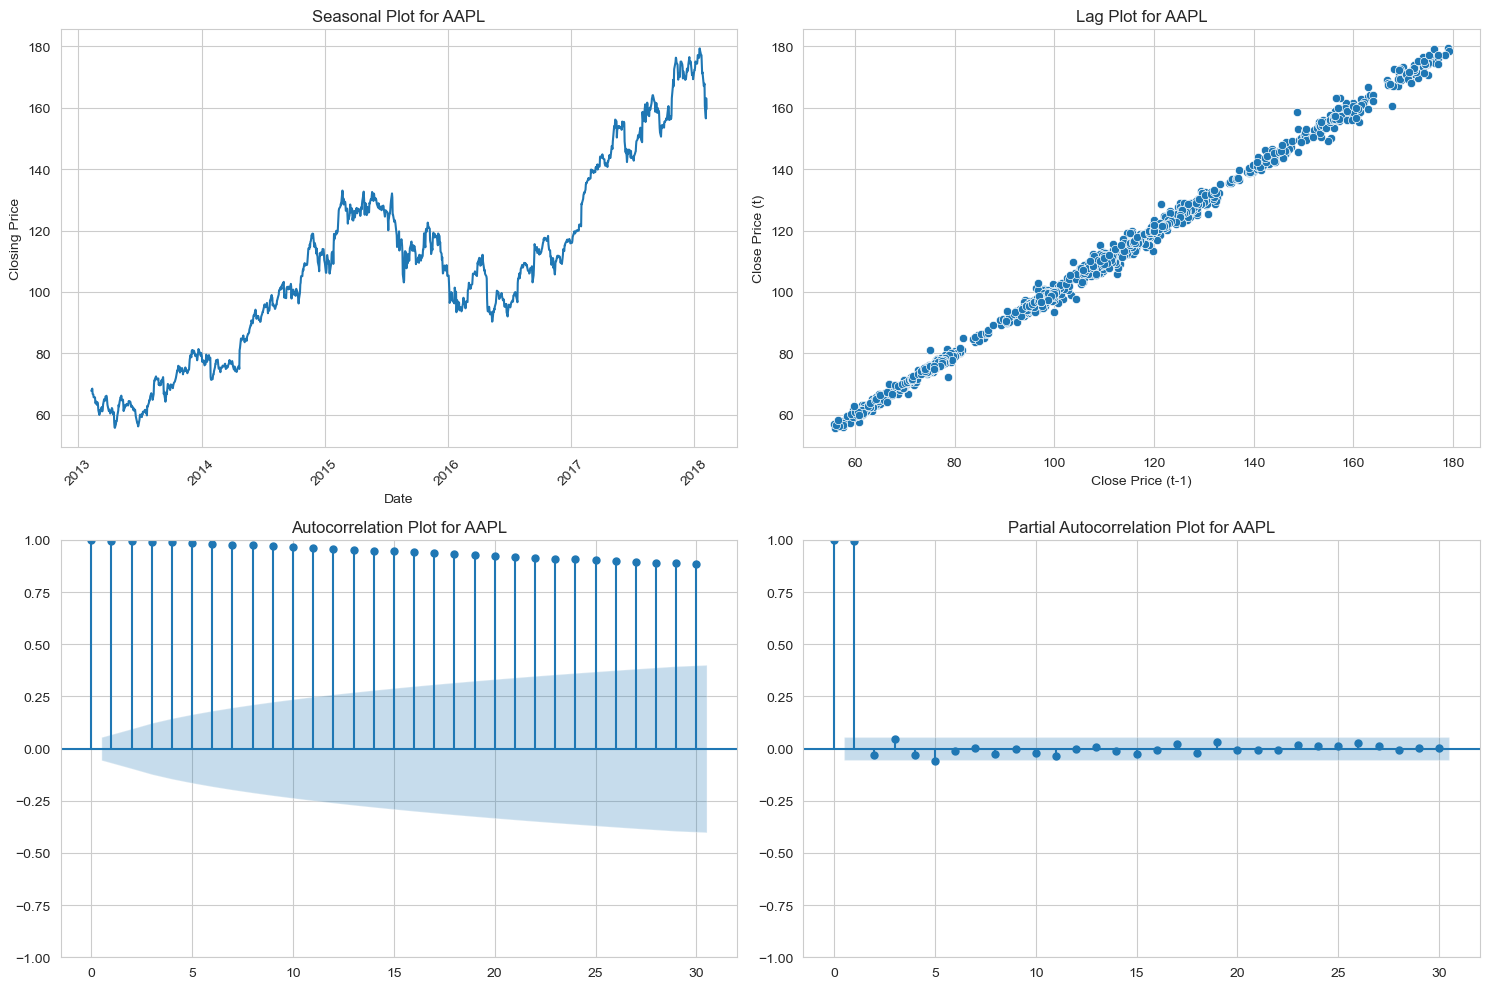

In [20]:
companies = polars['name'].unique().to_list()

# Ask user for company selection
print("Available companies:")
print(companies)
selected_company = input("Enter the company name for visualization: ")

# Ensure valid company selection
if selected_company not in companies:
    print("Invalid company name. Defaulting to the first company.")
    selected_company = companies[0]

company_df = polars.filter(pl.col('name') == selected_company).sort('date').to_pandas()

# Visualization - Subplot of all graphs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Seasonal Plot
sns.lineplot(ax=axes[0, 0], x=company_df['date'], y=company_df['close'])
axes[0, 0].set_title(f'Seasonal Plot for {selected_company}')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Closing Price')
axes[0, 0].tick_params(axis='x', rotation=45)

# Lag Plot
sns.scatterplot(ax=axes[0, 1], x=company_df['close'].shift(1), y=company_df['close'])
axes[0, 1].set_title(f'Lag Plot for {selected_company}')
axes[0, 1].set_xlabel('Close Price (t-1)')
axes[0, 1].set_ylabel('Close Price (t)')

# Autocorrelation Plot
plot_acf(company_df['close'].dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title(f'Autocorrelation Plot for {selected_company}')

# Partial Autocorrelation Plot
plot_pacf(company_df['close'].dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title(f'Partial Autocorrelation Plot for {selected_company}')

plt.tight_layout()
plt.show()

## E) Feature Selction

# Feature Selection:
> We include both raw stock data and technical indicators to provide the model with more context.

> Raw Stock Data: `open`, `high`, `low`, `volume`: These reflect daily price movement and market activity.

###  Technical Indicators:
> `EMA_10`: Tracks price trends over the last 10 days.
> 
> `MACD`: Captures momentum and trend direction.
>
> `ATR_14`: Measures volatility using the true range method.
> 
> `Williams_%R`: Identifies overbought or oversold conditions.

## Exponential Smoothing

In [21]:
companies = polars['name'].unique().to_list()

#### Finding the Best Exponential Smoothing For Forcasting

In [22]:
# List to store forecast results
forecasts_list = []

# Define possible Exponential Smoothing configurations
trend_options = [None, 'add']
seasonal_options = [None, 'add']
seasonal_periods_options = [7, 14, 30]

# Store best model configuration for each company
best_models = []

for company in companies:
    df_company = polars.filter(pl.col('name') == company).sort('date')
    
    # Ensure the 'close' column is float
    df_company = df_company.with_columns(pl.col('close').cast(float))
    close_prices = df_company['close'].to_numpy()
    
    # Skip if not enough data or contains NaN values
    if len(close_prices) < 10 or np.isnan(close_prices).any():
        continue
    
    # Store original mean and standard deviation for denormalization
    original_mean = np.mean(close_prices)
    original_std = np.std(close_prices)
    
    # Normalize data to prevent overflow
    close_prices = (close_prices - original_mean) / original_std
    
    # Find the best Exponential Smoothing model
    best_mse = float("inf")
    best_config = None
    best_forecast = [None] * 30  # Default to None if no valid model is found
    
    for trend in trend_options:
        for seasonal in seasonal_options:
            for seasonal_periods in seasonal_periods_options:
                if len(close_prices) < seasonal_periods:
                    continue  # Skip configurations with longer seasonal periods than available data
                try:
                    model = ExponentialSmoothing(close_prices, trend=trend, damped_trend=True, seasonal=seasonal, seasonal_periods=seasonal_periods)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(30).tolist()
                    mse = mean_squared_error(close_prices[-30:], forecast[:len(close_prices[-30:])])
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_config = (trend, seasonal, seasonal_periods)
                        best_forecast = forecast
                except:
                    continue
    
    # Denormalize forecasted values to bring them back to actual price scale
    best_forecast = [(val * original_std + original_mean) if val is not None else None for val in best_forecast]
    
    forecasts_list.append([company] + best_forecast)
    best_models.append([company, str(best_config), best_mse])

# Create column names for forecast days
forecast_dates = [f"Day_{i+1}" for i in range(30)]
forecasts_df = pl.DataFrame(forecasts_list, schema=['Company'] + forecast_dates, orient="row")
best_models_df = pl.DataFrame(best_models, schema=['Company', 'Best_Config', 'MSE'], orient="row")

### Results

In [23]:
forecasts_df

Company,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""PDCO""",33.857424,33.788076,33.804865,33.817312,33.79644,33.727433,33.885651,33.823545,33.806612,33.873492,33.932989,33.858498,34.025797,34.174814,34.154976,34.074729,34.009271,34.050298,33.908645,33.934197,34.017578,34.014316,34.103699,34.103806,34.047754,34.045978,33.883145,33.831517,33.85337,33.874946
"""AJG""",66.187445,66.031919,66.077578,65.951873,65.884587,65.881744,65.911263,65.867254,65.788033,65.765551,65.771535,65.663821,65.719008,65.752644,65.749495,65.779064,65.831052,65.817953,65.728259,65.772635,65.924546,65.974596,65.945288,65.932393,65.990618,65.980708,65.997572,66.040326,66.012154,66.11
"""HBI""",21.999047,21.91265,21.921965,21.837567,21.734245,21.805102,21.878496,21.883114,21.827523,21.944556,21.874478,21.929806,21.948585,22.041825,22.028999,21.910349,21.941173,21.921076,21.884501,21.853955,21.992306,21.988554,22.076595,22.054846,21.945261,21.845909,21.878651,21.985652,21.982416,21.963317
"""FB""",180.428594,180.326191,180.249815,180.376017,180.191325,180.352628,180.845047,181.00001,181.17316,181.163068,180.751007,180.509874,180.372946,180.604723,180.851193,180.746678,180.668199,180.792309,180.605535,180.764768,181.255126,181.408038,181.579149,181.567026,181.152946,180.909802,180.770876,181.000663,181.245153,181.138668
"""DIS""",104.760301,104.760601,104.7609,104.761196,104.761492,104.761786,104.762078,104.762369,104.762659,104.762947,104.763233,104.763518,104.763802,104.764085,104.764365,104.764645,104.764923,104.7652,104.765475,104.765749,104.766022,104.766293,104.766563,104.766831,104.767099,104.767364,104.767629,104.767892,104.768154,104.768415
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""FTI""",30.574315,30.510989,30.531352,30.488217,30.519353,30.504899,30.511672,30.574315,30.510989,30.531352,30.488217,30.519353,30.504899,30.511672,30.574315,30.510989,30.531352,30.488217,30.519353,30.504899,30.511672,30.574315,30.510989,30.531352,30.488217,30.519353,30.504899,30.511672,30.574315,30.510989
"""CBG""",42.639525,42.70385,42.649619,42.570549,42.598604,42.520949,42.52188,42.611673,42.565643,42.5768,42.507219,42.454324,42.469761,42.472814,42.585776,42.660851,42.61522,42.543029,42.576588,42.503336,42.507791,42.600401,42.556625,42.569586,42.501448,42.449707,42.466067,42.469859,42.583412,42.65896
"""FISV""",129.288598,129.288912,129.095364,129.106747,129.228113,129.211431,129.3892,129.523678,129.644624,129.597098,129.37159,129.363812,129.380465,129.31256,129.430446,129.43005,129.235797,129.246477,129.367144,129.349767,129.526844,129.660635,129.780896,129.732689,129.506503,129.49805,129.514031,129.445459,129.56268,129.561623


## E) Two Algorthim

In [24]:
features = ["open", "high", "low", "volume", "EMA_10", "MACD", "ATR_14", "Williams_%R"]
target = "close"

In [25]:
# Forecast storage for XGBoost and Random Forest
forecast_results = []
metrics_results = []
processed_companies = 0
skipped_companies = 0

for company in companies:
    df_company = polars.filter(pl.col('name') == company).sort('date')
    
    # Cast close column to float
    df_company = df_company.with_columns(pl.col(target).cast(float))
    
    # Check if at least 180 records are available
    if len(df_company) < 180:
        print(f"Skipping {company} due to insufficient data (less than 180 records)")
        skipped_companies += 1
        continue
    
    # Split data into X and Y
    X = df_company.select(features).to_numpy()
    y = df_company.select([target]).to_numpy().flatten()
    
    # Ensure enough data for training
    if len(X) < 2 or len(y) < 2:
        print(f"Skipping {company} due to not enough training data")
        skipped_companies += 1
        continue
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Ensure future data has the same shape as training data
    future_days = np.tile(X_test[-1].reshape(1, -1), (180, 1))  # Use last known feature row for future predictions
    
    # XGBoost Model
    try:
        xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)
        xgb_mse = mean_squared_error(y_test, xgb_pred)
        xgb_mae = mean_absolute_error(y_test, xgb_pred)
        xgb_r2 = r2_score(y_test, xgb_pred)
        xgb_forecast = xgb_model.predict(future_days)
    except Exception as e:
        skipped_companies += 1
        continue
    
    # Random Forest Model
    try:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_mse = mean_squared_error(y_test, rf_pred)
        rf_mae = mean_absolute_error(y_test, rf_pred)
        rf_r2 = r2_score(y_test, rf_pred)
        rf_forecast = rf_model.predict(future_days)
    except Exception as e:
        print(f"Skipping {company} due to Random Forest error: {e}")
        skipped_companies += 1
        continue
    
    # Store results
    forecast_results.append([company] + xgb_forecast.tolist() + rf_forecast.tolist())
    metrics_results.append([company, xgb_mse, xgb_mae, xgb_r2, rf_mse, rf_mae, rf_r2])
    processed_companies += 1
    

# Create forecast results dataframe
forecast_columns = ['Company'] + [f'XGB_Day_{i+1}' for i in range(180)] + [f'RF_Day_{i+1}' for i in range(180)]
forecast_df = pl.DataFrame(forecast_results, schema=forecast_columns, orient="row")

# Create metrics results dataframe
metrics_columns = ['Company', 'XGB_MSE', 'XGB_MAE', 'XGB_R2', 'RF_MSE', 'RF_MAE', 'RF_R2']
metrics_df = pl.DataFrame(metrics_results, schema=metrics_columns, orient="row")

# Display processed and skipped companies count
print(f"Total companies successfully processed: {processed_companies}")
print(f"Total companies skipped: {skipped_companies}")

# Display forecast results
print("Forecast Results for XGBoost and Random Forest:")
print(forecast_df)

# Display metrics results
print("\nPerformance Metrics for XGBoost and Random Forest:")
print(metrics_df)

Skipping BHF due to insufficient data (less than 180 records)
Skipping BHGE due to insufficient data (less than 180 records)
Skipping APTV due to insufficient data (less than 180 records)
Skipping DWDP due to insufficient data (less than 180 records)
Total companies successfully processed: 501
Total companies skipped: 4
Forecast Results for XGBoost and Random Forest:
shape: (501, 361)
┌─────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ Company ┆ XGB_Day_1  ┆ XGB_Day_2  ┆ XGB_Day_3  ┆ … ┆ RF_Day_177 ┆ RF_Day_178 ┆ RF_Day_179 ┆ RF_Day_180 │
│ ---     ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str     ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞═════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ PDCO    ┆ 36.850746  ┆ 36.850746  ┆ 36.850746  ┆ … ┆ 36.2938    ┆ 36.2938  

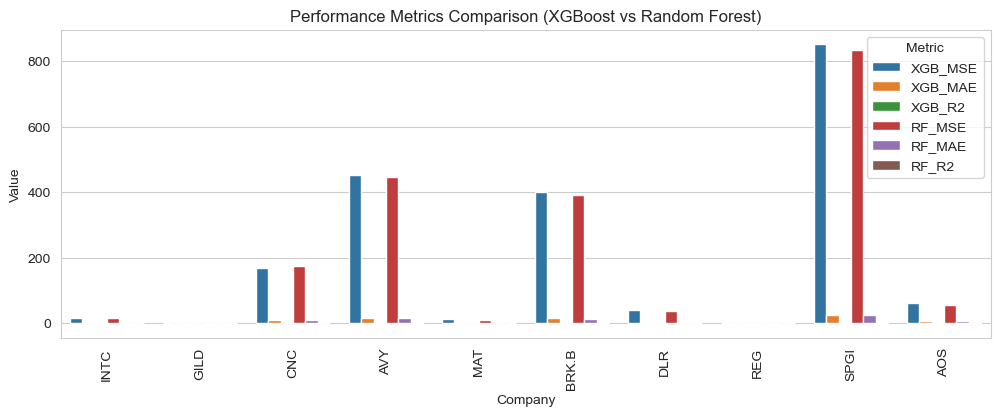

In [26]:
num_companies_to_plot = random.randint(7, 10)
selected_companies = random.sample(metrics_df['Company'].to_list(), min(num_companies_to_plot, len(metrics_df)))

# Visualization - Metrics Comparison
plt.figure(figsize=(12, 4))
sns.barplot(data=metrics_df.filter(pl.col('Company').is_in(selected_companies)).to_pandas().melt(id_vars=['Company'], var_name='Metric', value_name='Value'), x='Company', y='Value', hue='Metric')
plt.xticks(rotation=90)
plt.title('Performance Metrics Comparison (XGBoost vs Random Forest)')
plt.show()

In [27]:
# Function to plot forecast
def plot_forecast(company_name, days_to_forecast):
    if days_to_forecast > 180:
        days_to_forecast = 180
    
    # Extract forecast results for the selected company
    forecast_data = [row for row in forecast_results if row[0] == company_name]
    historical_data = polars.filter(pl.col('name') == company_name).sort('date')
    
    if forecast_data and len(historical_data) > 0:
        xgb_forecast = forecast_data[0][1:days_to_forecast+1]
        rf_forecast = forecast_data[0][days_to_forecast+1:days_to_forecast*2+1]
        days = np.arange(1, days_to_forecast+1)
        
        # Extract historical close prices
        historical_days = np.arange(1, len(historical_data) + 1)
        historical_close = historical_data.select([target]).to_numpy().flatten()
        
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        # XGBoost Forecast Plot
        axs[0].plot(days, xgb_forecast, label='XGBoost Forecast', marker='o', linestyle='--', color='blue')
        axs[0].set_title(f'XGBoost Forecast for {company_name}')
        axs[0].set_xlabel('Days')
        axs[0].set_ylabel('Predicted Value')
        axs[0].legend()
        axs[0].grid()
        
        # Random Forest Forecast Plot
        axs[1].plot(days, rf_forecast, label='Random Forest Forecast', marker='s', linestyle='-', color='green')
        axs[1].set_title(f'Random Forest Forecast for {company_name}')
        axs[1].set_xlabel('Days')
        axs[1].set_ylabel('Predicted Value')
        axs[1].legend()
        axs[1].grid()
        
        # Combined Historical and XGBoost Forecast Plot
        axs[2].plot(historical_days, historical_close, label='Historical Close Price', marker='.', linestyle='-', color='black')
        axs[2].plot(days + len(historical_days), xgb_forecast, label='XGBoost Forecast', marker='o', linestyle='--', color='blue')
        axs[2].set_title(f'Historical vs XGBoost Forecast for {company_name}')
        axs[2].set_xlabel('Days')
        axs[2].set_ylabel('Price')
        axs[2].legend()
        axs[2].grid()
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No forecast data found for {company_name}")

# Interactive widget
interact(plot_forecast, company_name=list(set(row[0] for row in forecast_results)), days_to_forecast=(1, 180, 1))

interactive(children=(Dropdown(description='company_name', options=('XYL', 'LUV', 'NBL', 'CPB', 'ABC', 'CSRA',…

<function __main__.plot_forecast(company_name, days_to_forecast)>